# RANDOMFOREST

Le randomforest sono un esempio di metodo basato su ensemble, ovvero un metodo che aggrega i risultati di un ensemble di modelli più semplici. Si fondano sul principio che il voto di maggioranza tra un insieme di estimatori semplici può essere più affidabile rispetto al voto dei singoli estimatori.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Alberi decisionali

La randomforest si basano su ensemble di alberi decisionali. Cosa è un albero decisionale?

[0, 1, 0, 1]

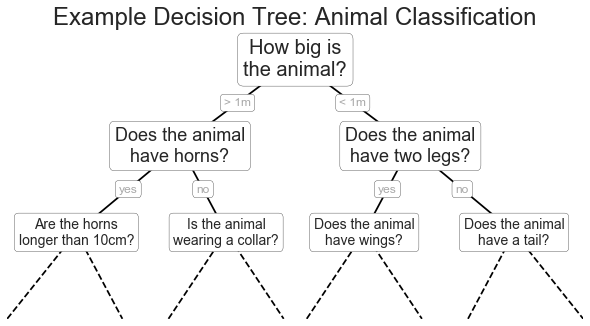

In [2]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

### Esempio di albero decisionale per classificare un oggetto con 2 features su 4 categorie:

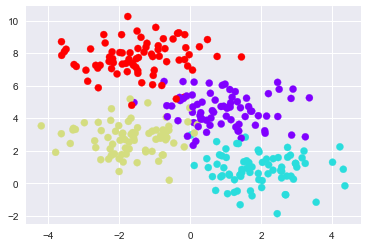

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');


In [4]:
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier().fit(X, y)

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

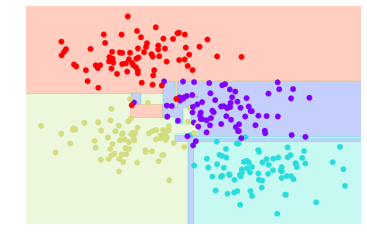

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

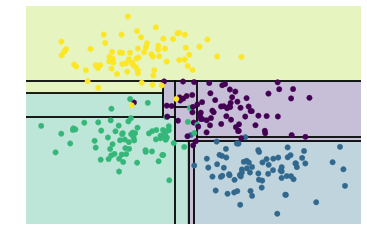

In [7]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

Man mano che la profondità aumenta le regioni di classificazione si complicano. Questo effetto è dovuto alla distibuzione intriseca dei dati, ma soprattutto al campionamento dei dati o al loro rumore. Il rischio di utilizzare profondità elevate è quello di produrre un modello affetto da overfitting.

L'overfitting è tipico degli alberi decisionali che oltre un certo livello di profondità tendono a fittare dettagli particolari dei dati piuttosto che le proprità saliente della distribuzione dei dati. Usando campioni diversi dei dati, cambiano le regioni del modello:

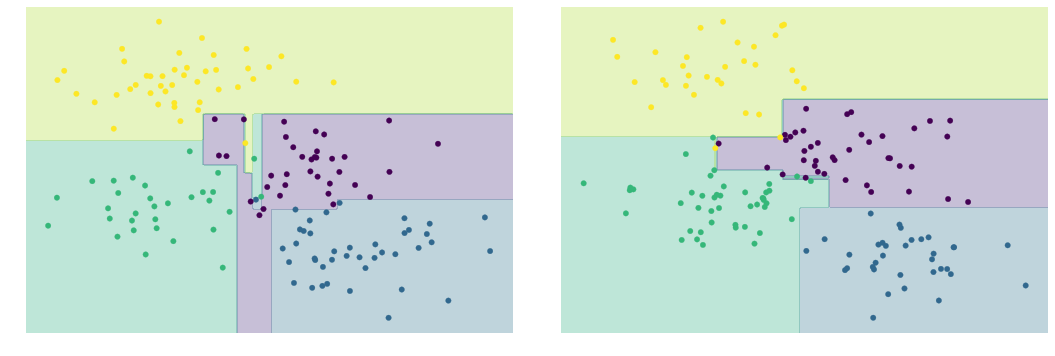

In [8]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
helpers_05_08.visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
helpers_05_08.visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

E' chiaro che le incosistenze avvengono in quelle regioni dove la classificazione è più incerta: questo induce a pensare che utilizzare il risultato prodotto da diversi alberi possa generare un risultato migliore.

Esempio di alberi decisionale allenati con un sottoinsieme casuale dei dati:

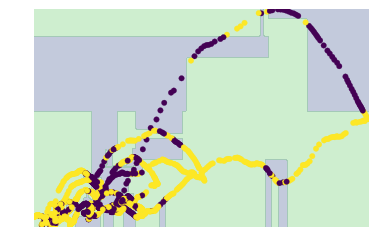

In [23]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

## Ensemble di alberi decisionali: randomforest

Il fatto che molti estimatori che overfittano i dati possano essere combinati per ridurre l'effetto di questo overfitting è alla base delle costruzione del concetto di randomforest. La combinazione di molti estimatori in parallelo è nota come bagging. Il bagging fa uso di molti estimatori in parallelo, ciuscuno dei quali overfitta i dati, e media sui risultati. Una random forest è un ensemble di alberi decisionali casuali.

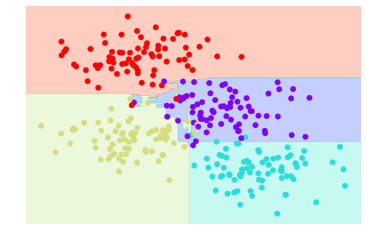

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In questo esempio gli alberi decisionali sono randomizzati fittando ciascuno di essi con un sottoinsieme casuale dei dati contenente l'80% dei dati. Gli alberi decisionale possono essere randomizzato anche iniettando rumore sulle singole decisioni effettuale. Scikit-learn implementa automaticamente tali strategie.

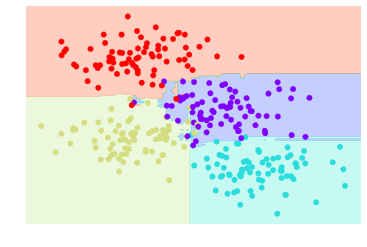

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Esempio: VIX e S&P500

Caricamento delle serie storiche di VIX e S&P500 da Gennaio 2007 a Febbraio 2017

In [12]:
import pandas as pd
ndaysVIX = 100
VIXclose = pd.read_csv('VIXCLS.csv', index_col=0, dtype={'VALUE': np.float64}, na_values='.')
VIXclose = VIXclose.dropna()
VIXrolling = pd.DataFrame()
VIXrolling['Mean'] = VIXclose.VALUE.rolling(window=ndaysVIX).mean()
VIXrolling['Median'] = VIXclose.VALUE.rolling(window=ndaysVIX).median()
VIXrolling['Std'] = VIXclose.VALUE.rolling(window=ndaysVIX).std()
VIXrolling = VIXrolling.dropna()
SP500close = pd.read_csv('SP500.csv', index_col=0, dtype={'VALUE': np.float64}, na_values='.')
SP500close = SP500close.dropna()
SP500close['RETURN'] =  (SP500close.VALUE.shift(-1)-SP500close.VALUE)/SP500close.VALUE
SP500close['BinReturn'] = SP500close['RETURN'].apply(lambda x: 1 if x > 0 else 0)
ndaysSP500 = 30
SP500rolling = pd.DataFrame()
SP500rolling['TotalAbsReturn'] = SP500close.VALUE.shift(-1*ndaysSP500)-SP500close.VALUE
SP500rolling['BinReturn'] = SP500rolling['TotalAbsReturn'].apply(lambda x: 1 if x > 0 else 0)
SP500rolling = SP500rolling.dropna()
MLData = pd.DataFrame()
F1 = 'Mean'
F2 = 'Std'
MLData['F1'] = VIXrolling[F1]
MLData['F2'] = VIXrolling[F2]
MLData['y'] = SP500rolling['BinReturn']
MLData = MLData.dropna()
print MLData.head(20)

                 F1        F2    y
DATE                              
2007-03-14  11.5134  2.006345  1.0
2007-03-15  11.5643  2.065592  1.0
2007-03-16  11.6232  2.129447  1.0
2007-03-19  11.6628  2.147535  1.0
2007-03-20  11.6847  2.152692  1.0
2007-03-21  11.6988  2.151323  1.0
2007-03-22  11.7215  2.152228  1.0
2007-03-23  11.7454  2.152469  1.0
2007-03-26  11.7690  2.154935  1.0
2007-03-27  11.7918  2.160908  1.0
2007-03-28  11.8306  2.183080  1.0
2007-03-29  11.8669  2.207736  1.0
2007-03-30  11.8991  2.224570  1.0
2007-04-02  11.9328  2.238741  1.0
2007-04-03  11.9558  2.242533  1.0
2007-04-04  11.9773  2.244454  1.0
2007-04-05  12.0021  2.244457  1.0
2007-04-09  12.0234  2.245054  1.0
2007-04-10  12.0423  2.242520  1.0
2007-04-11  12.0686  2.243935  1.0


Vengono scelte come feature i valori di media mobile e deviazione standard mobile del VIX sugli ultimi 100 giorni.
Il target è il segno del ritorno dello S&P500 nei prossimi 30 giorni.

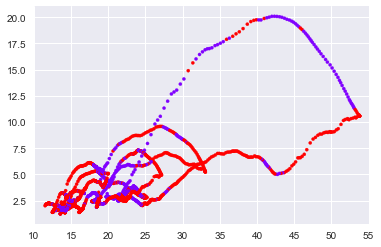

In [13]:
X = MLData[['F1','F2']].as_matrix()
y = MLData['y'].as_matrix()
plt.xlim(10,55)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='rainbow');

Implementazione di un albero decisionale

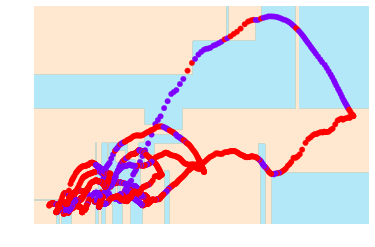

In [14]:
visualize_classifier(DecisionTreeClassifier(), X, y)

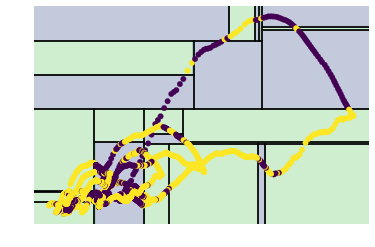

In [15]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

Implementazione di alberi decisionali randomizzati

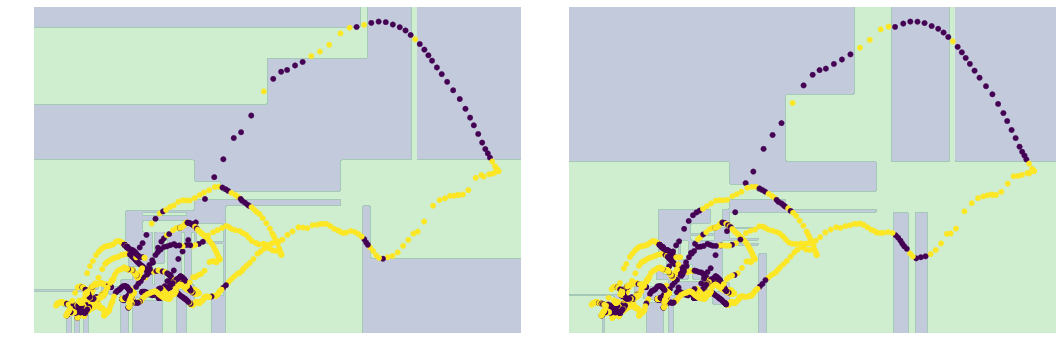

In [16]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
helpers_05_08.visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
helpers_05_08.visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

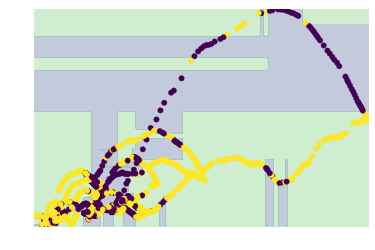

In [17]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

Ecco il modello randomforest

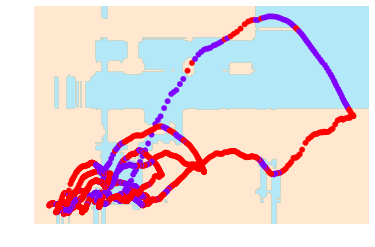

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Conclusioni

Le Random forests con un metodo molto potente con alcuni vantaggi:

•Velocità computazionale dell'algoritmo di training e dell'algotimo di predizione.

•L'utilizzo di un esemble di modelli permette una classificazione probabilistica(implementata in Scikit-Learn del metodo predict_proba()).

•Modello semplice e flessibile che garantisce buone performance dove spesso altri estimatori fanno underfit.